Dacon 태양광 발전량 예측

https://dacon.io/competitions/official/235680/overview/description

lstm 사용

boosting, decision tree 말고 NN으로 해결해보고 싶었는데 lstm을 사용했을때 lgbm과 제일 비슷하게 나왔다.



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jan 25 09:27:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from tqdm.notebook import tqdm_notebook as tqdm
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/data/날씨/'

df = pd.read_csv(path+'train/train.csv')


SAVEPATH = '/content/drive/My Drive/Colab Notebooks/대회/dacon 태양광/'

#test 가져오기
df_test = []

## 마지막 7일치만 가져오자
def preprocess_data(day,data):
	temp = data.copy()
	return temp.iloc[day * -48:, :]

for i in range(81):
  file_path = path+'test/' + str(i) + '.csv'
  temp = pd.read_csv(file_path)
  temp = preprocess_data(7,temp)
  df_test.append(temp)
device = 'cuda'

# test = pd.concat(df_test)
# Attach padding dummy time series
# X_test = X_test.append(X_test[-96:])
# test.shape

#submission
submission = pd.read_csv(path+'sample_submission.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## 

temp = pd.read_csv(SAVEPATH+'filename (18).csv')


In [ ]:
temp = submission.iloc[:,1:]
temp[temp < 0.3] = 0 

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.000970,-0.003137,0.000392,0.0,0.0,-0.014649,0.000959,-0.000553
1,0.csv_Day7_0h30m,0.0,-0.000133,0.001243,-0.001592,0.0,0.0,0.001681,0.000391,0.030167
2,0.csv_Day7_1h00m,0.0,-0.006992,-0.000287,-0.000845,0.0,0.0,0.076413,0.011586,-0.000740
3,0.csv_Day7_1h30m,0.0,-0.000236,-0.034953,-0.001794,0.0,0.0,-0.024947,0.001566,0.005791
4,0.csv_Day7_2h00m,0.0,0.000498,-0.059209,0.000504,0.0,0.0,-0.015525,0.002466,-0.001152
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.000042,-0.000058,0.010951,0.0,0.0,0.024903,0.031059,0.002718
7772,80.csv_Day8_22h00m,0.0,-0.000133,0.000121,0.023814,0.0,0.0,0.084256,0.035062,0.000344
7773,80.csv_Day8_22h30m,0.0,-0.000012,-0.000113,0.023454,0.0,0.0,0.094950,0.028037,0.001852
7774,80.csv_Day8_23h00m,0.0,-0.000729,-0.000392,-0.046756,0.0,0.0,0.027964,0.004882,0.014268


In [ ]:
for j in range(170):  
  for i in range(11):
    temp.iloc[48*j+i,1:] = 0
    temp.iloc[48*j+37+i,1:] = 0

## normalize

In [ ]:
def z_score_normalize(lst):
    normalized = []
    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)
    return normalized

In [ ]:
temp = (z_score_normalize(df["DNI"].values))


In [ ]:
normalized_df =  pd.DataFrame(data = temp,columns = ["DNI"])

In [ ]:
normalized_df["DHI"] = z_score_normalize(df["DHI"].values)
normalized_df["TARGET"] = z_score_normalize(df["TARGET"].values)

In [ ]:
normalized_df

,DNI,DHI,TARGET
0,-0.671447,-0.619312,-0.690638
1,-0.671447,-0.619312,-0.690638
2,-0.671447,-0.619312,-0.690638
3,-0.671447,-0.619312,-0.690638
4,-0.671447,-0.619312,-0.690638
...,...,...,...
52555,-0.671447,-0.619312,-0.690638
52556,-0.671447,-0.619312,-0.690638
52557,-0.671447,-0.619312,-0.690638
52558,-0.671447,-0.619312,-0.690638


In [ ]:
df.loc[(df['Hour'] > 19 )   & (df["TARGET"] != 0) , "TARGET"]


#5시부터 19시까지만 잡힌다.

Series([], Name: TARGET, dtype: float64)

In [ ]:
df["GHI"] = df["DHI"]+df["DNI"]

In [ ]:
df.loc[df['Minute']==30,'Hour'] +=0.5
df.drop(['Minute'],axis=1,inplace=True)
df

,Day,Hour,DHI,DNI,WS,RH,T,TARGET,GHI
0,0,0.0,0,0,1.5,69.08,-12,0.0,0
1,0,0.5,0,0,1.5,69.06,-12,0.0,0
2,0,1.0,0,0,1.6,71.78,-12,0.0,0
3,0,1.5,0,0,1.6,71.75,-12,0.0,0
4,0,2.0,0,0,1.6,75.20,-12,0.0,0
...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,0,0,2.4,70.70,-4,0.0,0
52556,1094,22.0,0,0,2.4,66.79,-4,0.0,0
52557,1094,22.5,0,0,2.2,66.78,-4,0.0,0
52558,1094,23.0,0,0,2.1,67.72,-4,0.0,0


In [ ]:
df[["Day",'DHI']][0:4]

,Day,DHI
0,0,0
1,0,0
2,0,0
3,0,0


## DATA


시간별 target으로만 target 유추

input 3 days

output 2 days

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):

  # find the end of this pattern
    i *= 48
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
  # gather input and output parts of the pattern
    # seq_x, seq_y = temp[["DNI","DHI","TARGET"]][i:end_ix], sequence["TARGET"][end_ix:out_end_ix]
    seq_x, seq_y = sequence[["DNI","DHI","TARGET"]][i:end_ix], sequence["TARGET"][end_ix:out_end_ix]
    seq_x, seq_y = sequence["TARGET"][i:end_ix], sequence["TARGET"][end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

raw_seq = df
# choose a number of time steps
day = 7
n_steps_in, n_steps_out = 48*day, 96
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [ ]:
X.shape

(1087, 336, 3)

## 정규화

In [ ]:
X_train.shape

torch.Size([978, 336, 2])

In [ ]:
data = np.array(X_train)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [ ]:
train_data_normalized

array([[-1.        ],
       [-1.        ],
       [-0.98999137],
       ...,
       [-1.        ],
       [-0.52959514],
       [-1.        ]], dtype=float32)

In [ ]:
X_train = train_data_normalized.reshape(978,336,2)

In [ ]:
X_train[0]

In [ ]:
X_test.shape

torch.Size([109, 336, 1])

In [ ]:
data = np.array(X_test)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))
X_test = train_data_normalized.reshape(X_test.shape[0],X_test.shape[1])

## variable

In [ ]:
from torch.autograd import Variable


X_train = Variable(torch.Tensor(X_train))
X_test = Variable(torch.Tensor(X_test))
y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test))
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print("train shape is:",X_train.size())
print("train label shape is:",y_train.size())
print("test shape is:",X_test.size())
print("test label shape is:",y_test.size())

train shape is: torch.Size([978, 336, 1])
train label shape is: torch.Size([978, 96])
test shape is: torch.Size([109, 336, 1])
test label shape is: torch.Size([109, 96])


## simple LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [ ]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
#####  Parameters  ######################
num_epochs = 1500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 96

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(X_train.to(device))
    optimizer.zero_grad()
    


    # obtain the loss function
    loss = criterion(outputs, y_train.to(device))
 
    loss.backward()
    
    
    optimizer.step()
    


    #Evaluate on test     
    lstm.eval()
    valid = lstm(X_test.to(device))
    vall_loss = criterion(valid, y_test.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.67896 valid loss:  0.66605 
Epoch: 50, loss: 0.19902 valid loss:  0.11293 
Epoch: 100, loss: 0.19816 valid loss:  0.11060 
Epoch: 150, loss: 0.19909 valid loss:  0.11036 
Epoch: 200, loss: 0.19926 valid loss:  0.11037 
Epoch: 250, loss: 0.20010 valid loss:  0.11039 
Epoch: 300, loss: 0.19740 valid loss:  0.11045 
Epoch: 350, loss: 0.19873 valid loss:  0.11037 
Epoch: 400, loss: 0.19889 valid loss:  0.11038 
Epoch: 450, loss: 0.20035 valid loss:  0.11037 
Epoch: 500, loss: 0.19926 valid loss:  0.11037 
Epoch: 550, loss: 0.20049 valid loss:  0.11037 
Epoch: 600, loss: 0.19795 valid loss:  0.11038 
Epoch: 650, loss: 0.19807 valid loss:  0.11037 
Epoch: 700, loss: 0.20016 valid loss:  0.11038 
Epoch: 750, loss: 0.19905 valid loss:  0.11039 
Epoch: 800, loss: 0.20170 valid loss:  0.11038 
Epoch: 850, loss: 0.19970 valid loss:  0.11037 
Epoch: 900, loss: 0.19823 valid loss:  0.11037 
Epoch: 950, loss: 0.19868 valid loss:  0.11037 
Epoch: 1000, loss: 0.20035 valid loss:  0.1

In [ ]:
y.shape

(1091, 96)

## Multi LSTM layers

In [ ]:
## many to many 로 구현해보자
# batch, seq, inputsize
# input [981, 144, 1]
# output [981, 96]

#input of shape (seq_len, batch, input_size)



class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers,batch_first=True)
       
        
        self.fc1 = nn.Linear(hidden_size, int(num_classes))
        # self.fc2 = nn.Linear(hidden_size, int(num_classes/2))
        # self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(p=0.2)

        self.count = 0

        # 지금 형태는 맨마지믁 lstm에서 마지막 layer의 hidden size 만 가져와서 그대로 fc로 보내는거임

    def forward(self, x):
        # print(f'x.size(0) : {x.size(0)}') #981
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        # 2, 981, 512
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        # self.count += 1
        # print(self.count)


        out1, (hn, cn) = self.LSTM2(x, (h_1, c_1))
        #out1: batch_size, seq, hidden_size
        # torch.Size([batch, seq, hidden])
        #  1 print(out1[-1,-1,:])


        # train
        # hidden state shpe is: torch.Size([2, batch, hidden])
        # final state shape is: torch.Size([981, 512])
        # output size : torch.Size([981, 96])
        # valid
        # hidden state shpe is: torch.Size([2, 110, 512])
        # final state shape is: torch.Size([110, 512])
        # torch.Size([110, 96])
        
        # print("hidden state shpe is:",hn.size())
        # y = hn.view(-1, self.hidden_size)
        
        # final_1_state = out1[:,-2,:]
        final_state = out1[:,-1,:]
        
   
        # 2 print(final_state[-1,:]) 1 = 2
        # print(final_state[1:10,:10])

        # print("final state shape is:",final_state.shape)
        # out = F.relu(self.fc1(final_state))

        out1 = self.fc1(final_state)
        # out2 = self.fc2(final_state)

        #out = self.dropout(out)
        # print(out.size())
        return out1
    
 

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        # nn.init.uniform_(param.data, -0.1, 0.1)

# def quantile_loss(preds, target, quantiles):
#     assert not target.requires_grad
#     assert preds.size(0) == target.size(0)
#     losses = []
#     for i, q in enumerate(quantiles):
#         errors = target - preds[:, i]
#         losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
#     loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
#     return loss

def quantile_loss(preds, target, q):
  assert not target.requires_grad
  assert preds.size(0) == target.size(0)
  losses = []
  errors = target - preds
  losses.append(torch.mean(torch.max((q - 1) * errors, q * errors)))
  loss = torch.mean(torch.stack(losses))  
  return loss

## early stop

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            pass
            # print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Train

해볼거
1. 3일이아닌 7일치데이터 넣어서 학습
2. VALID도 다 학습
3. LSTM 모델 수정
4. HYPER PARAMETER 수정
5. sgd 사용
6. lstm weight init


//
num layer 늘려도 별 소용없음
hidden size도 마찬가지 

그래도 좀더 해볼것


In [ ]:
# ## 배치 사이즈 줄여서해보자

X_train = X_train[:800,:,:]
y_train = y_train[:800,:]

In [ ]:
# X_test = X_test[:80,:,:]
# y_test = y_test[:80,:]

In [ ]:
X_test[0][:48]

In [ ]:
# 0.1 Epoch: 152, loss: 1.42414 valid loss:  1.43572 
# 0.2 Epoch: 222, loss: 2.57128 valid loss:  2.55931 
# 0.3 Epoch: 251, loss: 3.33700 valid loss:  3.33624 

# 0.4 3.41628  epoch 500 이상부터 비슷
# 0.5 850
# 0.6 4.15723 200이상 
# 0.7  2.25036  500 이상
# 0.8  2.84159  300,
# 0.9  1.65140 250


# for quantile in  np.arange(0.1, 1, 0.1):
for quantile in  [0.7]:

  patience = 600

  early_stopping = EarlyStopping(patience = patience, verbose = True)

  num_epochs = 1100
  learning_rate = 1e-1
  input_size = 1
  hidden_size = 512
  num_layers = 2

  num_classes = 96
  # quantile = 0.3


  quantile = round(quantile, 2)
  print(f'Quantile : {quantile}')

  lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
  lstm.to(device)


  lstm.apply(init_weights)


  criterion = quantile_loss    # mean-squared error for regression
  # criterion = torch.nn.L1Loss().to(device)    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay= 1e-5)
  # optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate,momentum=0.9)

  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience= 60, 
  #           factor =0.1 ,min_lr=1e-6, eps=1e-08)

  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[400,700,900,1000], gamma=0.1)

  for epoch in progress_bar(range(num_epochs+1)): 

    lstm.train()
    outputs = lstm(X_train.to(device))
    # out1,out2 = lstm(X_train.to(device))
    optimizer.zero_grad()
    # obtain the loss function

    loss = criterion(outputs, y_train.to(device),quantile)
    # loss1 = criterion(out1, y_train[:,:48].to(device),quantile)
    # loss2 = criterion(out2, y_train[:,48:96].to(device),quantile)
    # loss = criterion(outputs, y_train.to(device))

    # loss = loss1+loss2
    loss.backward()

    scheduler.step()
    # torch.nn.utils.clip_grad_norm_(lstm.parameters(), 10)

    optimizer.step()


    lstm.eval()
    valid = lstm(X_test.to(device))
    # out1,out2 = lstm(X_test.to(device))


    #inverse
    # valid = torch.from_numpy(scaler.inverse_transform(valid.cpu().detach().numpy()))

    # vall_loss = criterion(torch.cat((out1,out2),1), y_test.to(device),quantile)
    vall_loss = criterion(valid, y_test.to(device),quantile)
    # vall_loss = criterion(valid, y_test.to(device))
    if epoch % 10 == 0:
      # print(criterion1(outputs, y_train.to(device),quantile))

      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item(),
                                                                     optimizer.param_groups[0]["lr"]))
    # scheduler.step(vall_loss)


    

    torch.save(lstm.state_dict(), SAVEPATH+'model_weight.pth')
    # model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

  #   # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
  #     # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
  #   early_stopping(round(vall_loss.item(),7), lstm)

  #   if early_stopping.early_stop:
  #       print("Early stop!!!! last Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item(),optimizer.param_groups[0]["lr"]))
  #       break

  # # best model이 저장되어있는 last checkpoint를 로드한다.
  #   lstm.load_state_dict(torch.load('checkpoint.pt'))


  outputs = []
  for i in range(81):
    #test중 target만 사용
    # normalized_df["TARGET"] = z_score_normalize( df_test[i]["TARGET"].values)
    # normalized_df["DNI"] = z_score_normalize( df_test[i]["DNI"].values)
    # normalized_df["DHI"] = z_score_normalize(df_test[i]["DHI"].values)

    # test = Variable(torch.Tensor(normalized_df[["DNI","DHI","TARGET"]].values))
    test = Variable(torch.Tensor(df_test[i]["TARGET"][-48*day:].values))
    output = lstm(test.reshape(1,48*day,1).to(device))
    # (output.cpu().detach().numpy()[0].reshape(-1, 1))
    # scaler.inverse_transform(output.cpu().detach().numpy()[0].reshape(-1, 1))

    outputs.append(output[0])

  submission[f'q_{quantile}'] = (torch.stack(outputs).reshape(-1).cpu().detach().numpy() )
  print(submission[f'q_{quantile}'][:96])


In [ ]:
print(day)
outputs = []
for i in range(81):
  #test중 target만 사용
  # normalized_df["TARGET"] = z_score_normalize( df_test[i]["TARGET"].values)
  # normalized_df["DNI"] = z_score_normalize( df_test[i]["DNI"].values)
  # normalized_df["DHI"] = z_score_normalize(df_test[i]["DHI"].values)

  # test = Variable(torch.Tensor(normalized_df[["DNI","DHI","TARGET"]].values))
  test = Variable(torch.Tensor(df_test[i]["TARGET"][-48*day:].values))
  output = lstm(test.reshape(1,48*day,1).to(device))
  # (output.cpu().detach().numpy()[0].reshape(-1, 1))
  # scaler.inverse_transform(output.cpu().detach().numpy()[0].reshape(-1, 1))

  outputs.append(output[0])

submission[f'q_{quantile}'] = (torch.stack(outputs).reshape(-1).cpu().detach().numpy() )
print(submission[f'q_{quantile}'][:96])

5
0     0.000273
1    -0.000134
2    -0.000214
3     0.000177
4     0.000297
        ...   
91   -0.000170
92    0.000036
93    0.000038
94   -0.000160
95   -0.000025
Name: q_0.5, Length: 96, dtype: float32


In [ ]:
valid = lstm(X_test.to(device))
# valid = scaler.inverse_transform(valid.cpu().data.numpy())


tensor([[-1.0454, -1.1624, -1.1962,  ..., -0.9884, -0.9627, -1.0567],
        [-1.0454, -1.1624, -1.1962,  ..., -0.9884, -0.9627, -1.0567],
        [-1.0453, -1.1624, -1.1962,  ..., -0.9884, -0.9627, -1.0566],
        ...,
        [-1.0453, -1.1624, -1.1962,  ..., -0.9884, -0.9627, -1.0566],
        [-1.0453, -1.1624, -1.1961,  ..., -0.9884, -0.9627, -1.0566],
        [-1.0453, -1.1624, -1.1962,  ..., -0.9884, -0.9627, -1.0566]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([ -2.2658,  -8.1123,  -9.7997,  -9.5316,  -5.3287,   4.8741,  -3.9554,
          3.0132,  -1.3174,  -7.9347,  11.2503,  -0.9712,  -3.6404,   4.3413,
          6.8301,  12.5756,  20.2354,  29.4005,  32.9436,  40.0451,  45.3615,
         49.2281,  50.0133,  49.7319,  49.9096,  48.4559,  44.6433,  41.5174,
         38.3073,  31.6345,  26.0573,  20.6828,  12.7632,   7.5523,   2.8976,
         -0.1291,  -0.5744,   1.7223,   1.5254,   6.5075,   7.2917,  -5.5658,
          0.9025,  -3.3291,  -3.2819,   0.5226,  

In [ ]:

outputs = []
for i in range(81):
  #test중 target만 사용
  test = Variable(torch.Tensor(df_test[i]["TARGET"].values))
  output = lstm(test.reshape(1,48*7,1).to(device))
  (output.cpu().detach().numpy()[0].reshape(-1, 1))
  # scaler.inverse_transform(output.cpu().detach().numpy()[0].reshape(-1, 1))

  outputs.append(output[0])

submission[f'q_{quantile}'] = (torch.stack(outputs).reshape(-1).cpu().detach().numpy() )
print(submission[f'q_{quantile}'][:96])

0    -0.024616
1    -0.005030
2    -0.023621
3     0.001684
4    -0.013990
        ...   
91    0.003248
92   -0.014112
93    0.002327
94   -0.008257
95   -0.011697
Name: q_0.4, Length: 96, dtype: float32


## valid  시각화해보자 

In [ ]:
X_test[1,:,0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.4077,
         7.8832, 15.5786, 23.1797, 30.0300, 35.9418, 40.7277, 44.1994, 46.2640,
        46.9203, 35.9410, 43.8236, 40.2581, 35.3787, 29.3731, 15.8598,  9.6661,
         4.6923,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         8.0712, 16.0483, 23.9317, 31.0640, 37.1638, 42.0438, 45.5162, 47.5809,
        48.2373, 47.3927, 29.6556, 32.0021,  8.4463,  7.0386,  1.8770,  0.7508,
         0.3754,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [ ]:
lstm = LSTM2(96, 1, 512, 2).to(device)
lstm.eval()
lstm(X_test.reshape(110,144,1).to(device))

1
hidden state shpe is: torch.Size([2, 110, 512])
tensor([[ 0.0092, -0.0160,  0.0136, -0.0184,  0.0110,  0.0187, -0.0087,  0.0375,
          0.0208, -0.0248],
        [ 0.0092, -0.0160,  0.0136, -0.0183,  0.0109,  0.0187, -0.0086,  0.0375,
          0.0209, -0.0249],
        [ 0.0091, -0.0159,  0.0136, -0.0182,  0.0109,  0.0186, -0.0085,  0.0375,
          0.0210, -0.0252],
        [ 0.0092, -0.0171,  0.0137, -0.0253,  0.0133,  0.0175, -0.0117,  0.0370,
          0.0160, -0.0178],
        [ 0.0093, -0.0162,  0.0137, -0.0197,  0.0115,  0.0186, -0.0094,  0.0374,
          0.0198, -0.0235],
        [ 0.0094, -0.0164,  0.0136, -0.0201,  0.0115,  0.0186, -0.0099,  0.0373,
          0.0193, -0.0225],
        [ 0.0092, -0.0170,  0.0136, -0.0243,  0.0129,  0.0178, -0.0115,  0.0370,
          0.0165, -0.0186],
        [ 0.0094, -0.0165,  0.0137, -0.0213,  0.0120,  0.0184, -0.0103,  0.0373,
          0.0185, -0.0216],
        [ 0.0095, -0.0169,  0.0135, -0.0221,  0.0120,  0.0184, -0.0108,  0.036

tensor([[ 0.0084, -0.0026, -0.0193,  ...,  0.0112, -0.0078,  0.0069],
        [ 0.0084, -0.0027, -0.0193,  ...,  0.0112, -0.0079,  0.0069],
        [ 0.0084, -0.0027, -0.0193,  ...,  0.0112, -0.0079,  0.0069],
        ...,
        [ 0.0084, -0.0028, -0.0192,  ...,  0.0112, -0.0080,  0.0068],
        [ 0.0084, -0.0028, -0.0192,  ...,  0.0112, -0.0080,  0.0068],
        [ 0.0084, -0.0027, -0.0193,  ...,  0.0112, -0.0079,  0.0069]],
       device='cuda:0', grad_fn=<AddmmBackward>)

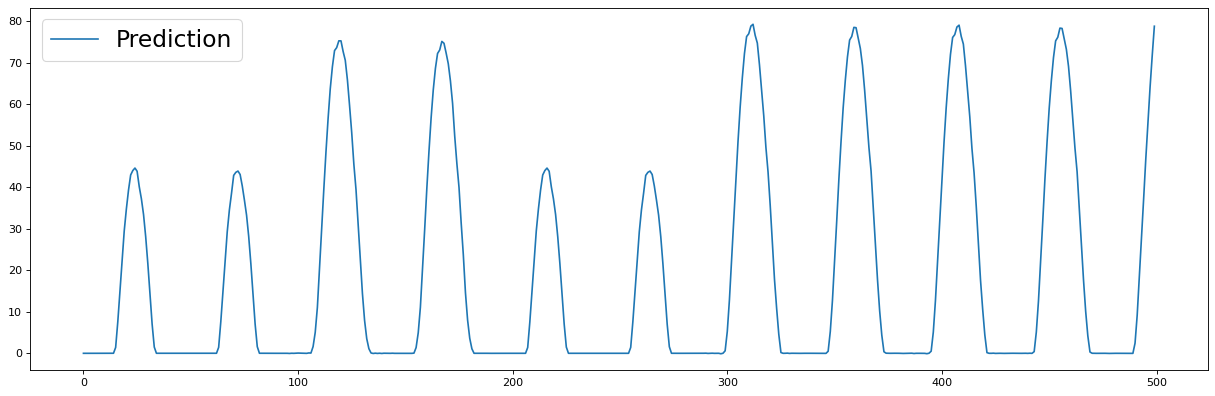

In [ ]:
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
lstm.eval()
valid = lstm(X_test.to(device)).cpu().detach().numpy()
y = y_test


# Inverse Normalize 
# valid = scaler.inverse_transform(valid)
# y = scaler.inverse_transform(y)

plt.plot(valid.reshape(1,-1)[0][:500])

# plt.plot(y.reshape(1,-1)[0][:1000])

plt.legend(['Prediction','Time Series'],fontsize = 21)


(1, 96)
(1, 96)


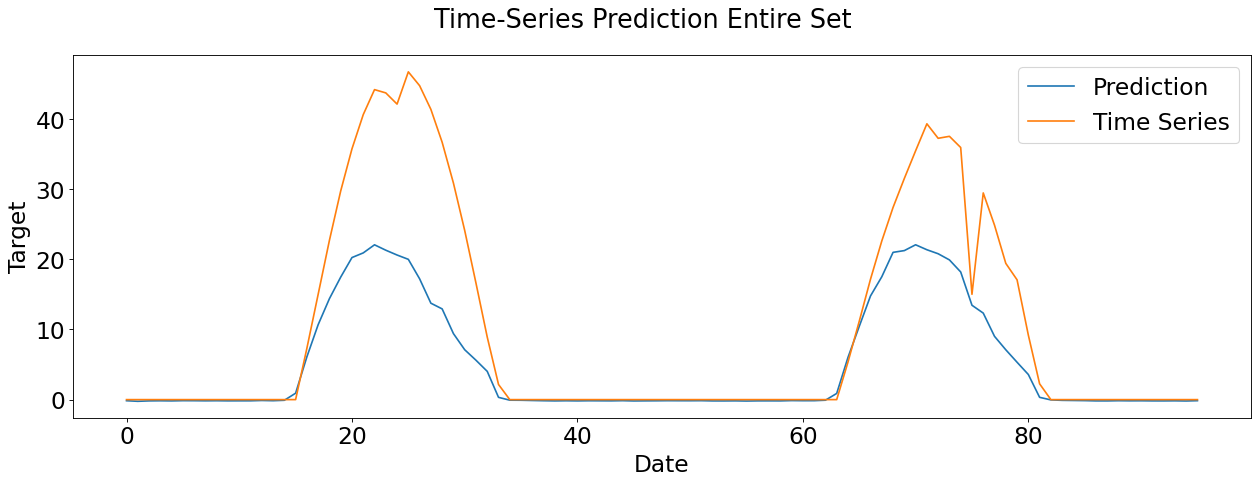

In [ ]:
# ######Prediction###############

# dataX = Variable(torch.Tensor(df['TARGET'][-(144+96):-96].values))
# dataY = Variable(torch.Tensor(df['TARGET'][-96:].values))
# dataX = dataX.reshape(1,dataX.shape[0],1)


# lstm.eval()
# train_predict = lstm(dataX.to(device))
# data_predict = train_predict.cpu().data.numpy()
# dataY_plot = [dataY.data.numpy()]
# # dates_list = range


# # Inverse Normalize 
# data_predict = scaler.inverse_transform(data_predict)
# dataY_plot = scaler.inverse_transform(dataY_plot)


# print(data_predict.shape)
# print(dataY_plot.shape)


# ## Add dates
# df_predict = pd.DataFrame(data_predict[0])
# # df_predict = df_predict.set_index([dates_list[:-29]])
# df_labels = pd.DataFrame(dataY_plot[0])
# # df_labels = df_labels.set_index([dates_list[:-29]])

# # Plot 
# figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
# # plt.axvline(x=dates_list[train_size], c='r')
# plt.plot(df_predict)
# plt.plot(df_labels)
# plt.legend(['Prediction','Time Series'],fontsize = 21)
# plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
# plt.xticks(fontsize=21 )
# plt.yticks(fontsize=21 )
# plt.ylabel(ylabel = 'Target',fontsize = 21)
# plt.xlabel(xlabel = 'Date',fontsize = 21)
# plt.show()

## submission

In [ ]:

df_test = []
submission = pd.read_csv(path+'sample_submission.csv')

## 마지막 3일치만 가져오자
def preprocess_data(day,data):
	temp = data.copy()
	return temp.iloc[day * -48:, -1]

for i in range(81):
  file_path = path+'test/' + str(i) + '.csv'
  temp = pd.read_csv(file_path)
  temp = preprocess_data(3,temp)
  df_test.append(temp)

# # normalize
# data = np.array(df_test)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# train_data_normalized = scaler.fit_transform(data)

In [ ]:

outputs = []
for i in range(81):
  test = Variable(torch.Tensor(df_test[i].values))
  output = lstm(test.reshape(1,144,1).to(device))
  (output.cpu().detach().numpy()[0].reshape(-1, 1))
  # scaler.inverse_transform(output.cpu().detach().numpy()[0].reshape(-1, 1))

  outputs.append(output[0])

submission[f'q_{quantile}'] = (torch.stack(outputs).reshape(-1).cpu().detach().numpy() )




In [ ]:
 submission[:48]

## 음수인거 0으로 치환

5시 19시 사이만 값 갖게하자


In [ ]:
submission = pd.read_csv(SAVEPATH+'filename (18).csv')

In [ ]:
for j in range(170):  
  for i in range(11):
    submission.iloc[48*j+i,1:] = 0
    submission.iloc[48*j+37+i,1:] = 0

In [ ]:
submission[-50:]

In [ ]:
temp = submission.iloc[:,1:]
temp[temp < 0] = 0 


In [ ]:
submission.iloc[:,1:] = temp

In [ ]:
from google.colab import files
submission.to_csv('filename.csv', index = False) 
files.download('filename.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0치환전에 2.88
0으로 바꾸니까 2.27981


In [ ]:
submission[:50]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
